# Youtube Video Content Group Characteristics

As the most popular video hosting and sharing website, Youtube hosts a huge number of videos of diverse content types. For a long time, it is difficult to generate or collect data about the content type of a video and analyse the major content groups on Youtube and their characteristics. This year, Google launched a Youtube video understanding competition on Kaggle, challenging machine learning practiioners around the world to tackle the video content tagging problem. Provided in the competition is a large sample (~4 million) of Youtube videos together with their corresponding tags. While the task of generating tasks for videos is beyond the scope of this project, we are still able to take this labelled sample of Youtube videos and gain some insights into the various types of content that exist on Youtube. We are especially interested in the following questions:
1. What are the most popular types of videos on Youtube?
2. Of the most common video content tags, which tags often appear on a same video? What are the content clusters and what are the dominant tags in each cluster?
3. Are there any perculiarities (length, views, likes, comments, likes vs dislikes, etc.) in videos of a particular popular tag or cluster?
4. Are there any changes in popularity over the years for the most common tags and clusters?
5. What is the view count / like count inequality among Youtube channels? What about for a certain tag / cluster?
6. (Advanced) are there any correlations between video title and popularity?

Information about the video sampling can be found at https://research.google.com/youtube8m/. Here is the original description:

>The videos are sampled uniformly to preserve the diverse distribution of popular content on YouTube, subject to a few constraints selected to ensure dataset quality and stability:

>+ Each video must be public and have at least 1000 views
>+ Each video must be between 120 and 500 seconds long
>+ Each video must be associated with at least one entity from our target vocabulary
>+ Adult & sensitive content is removed (as determined by automated classifiers)

The label data is taken from https://www.kaggle.com/c/youtube8m/data. We only use the labelled section of the data, in train_labels.csv.

We retrieve additional metadata about videos (such as title, channel, duration, views, likes, dislikes and comments) using the Youtube Data API found at https://developers.google.com/youtube/v3/.

### Data Loading and Preliminary Analysis

As a first step, we load the video tags data and look at what we have:

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML

In [8]:
# first we load the names of the labels:
%matplotlib inline

labels = pd.read_csv("../label_names.csv")
display(labels.head())

# then the table of video labels:
videos = pd.read_csv("../train_labels.csv", header=None)
videos.columns = ['video_id', 'labels']
display(videos.head())

,label_id,label_name
0,0,Games
1,1,Vehicle
2,2,Video game
3,3,Concert
4,4,Car


,video_id,labels
0,--DwgB78t-c,16 5 430
1,--NZRkXBV7k,128 3 39 7 44 13 16 30
2,--hoQ2sGG4M,694
3,--ABhs9ik7c,2232 1 4 517 270
4,--sBoaqBlzA,45 125


The video sampling process above used by Google is not entirely unbiased, however it still covers a large portion of publically visible videos available. Assuming it is a representative sample of public videos on Youtube, we are already able to identify the most popular content labels.

Here, we do not associate video views with the labels, instead only look at the number of unique videos under each label. We can think of this as the popularity of this label among content creators, whereas the average views for each label can be thought of as the popularity among viewers.

In [9]:
from collections import Counter
from itertools import chain
separated = videos['labels'].apply(lambda x: x.split(" "))
all_labels = list(chain.from_iterable(separated))
labels_count = Counter(all_labels)
col_counts = labels['label_id'].apply(lambda x: labels_count[str(x)])
labels['count'] = col_counts

Let us put the top 10 content labels on Youtube into a bar chart:

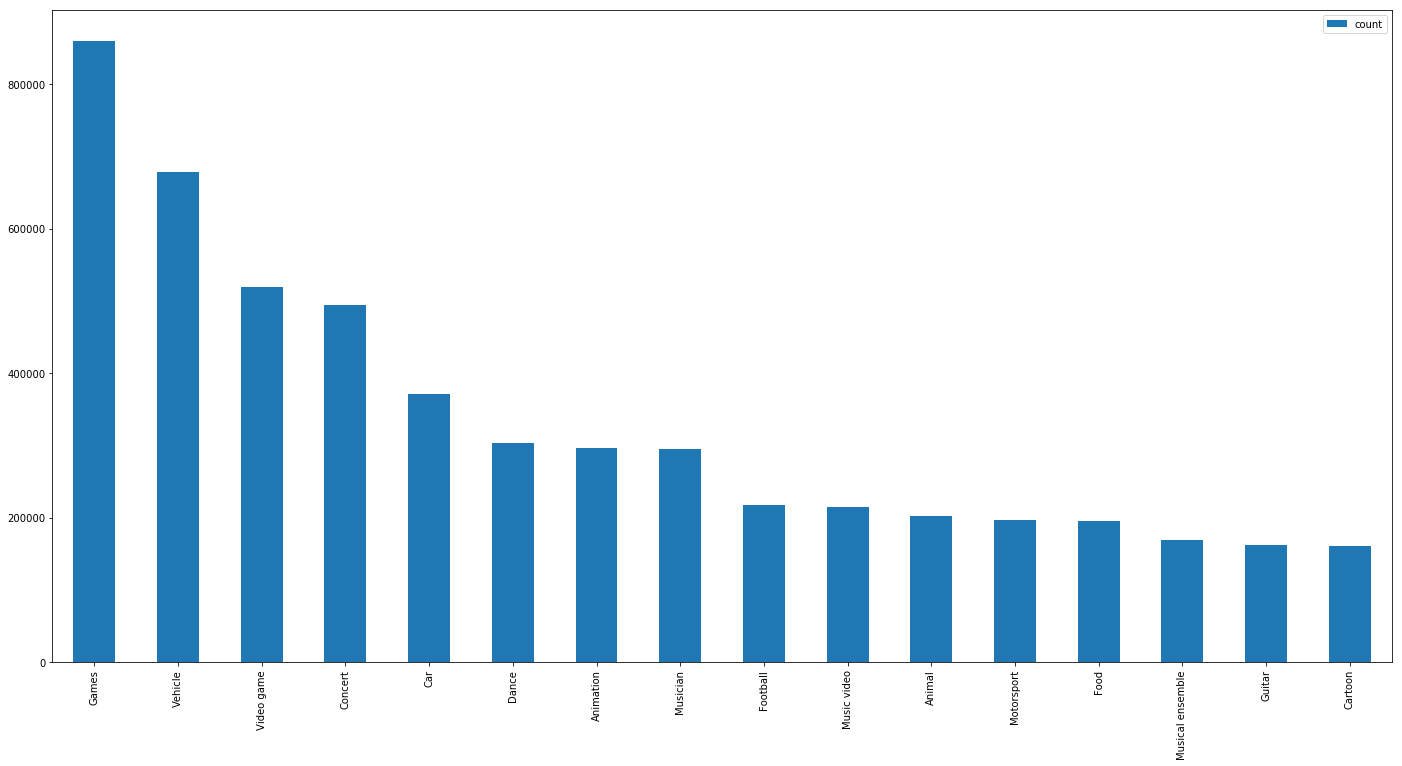

In [5]:
labels.ix[:15, 1:].plot.bar(figsize=(24, 12))
plt.xticks(range(16), labels.ix[:15, 1], rotation='vertical')
plt.show()

Now that we can identify the most popular labels on Youtube, how do we find the relationship between these labels? One video can have multiple labels, and many labels share similar meanings or refer to slightly different aspects of the same topic. However, sometimes videos share labels because the video content is an overlap between two usually unrelated topics. It is reasonable to assume that two tags are more likely to be semantically related if they appear more often on a same video. Based on this information, we are able to estimate the closeness of two labels, and later create a semantic clustering map of the most popular labels.

We first create a 1/0 encoded version of the labels table. It is then easy to calculate the coincidence matrix for the labels. We can visualise the coincidence matrix and identify relationships between labels:

In [43]:
from scipy.sparse import dok_matrix
N_LABELS = labels.shape[0]
N_VIDEOS = videos.shape[0]

def string_to_list(s):
    return np.fromstring(s, dtype=np.uint16, sep=' ')

binary_mat = dok_matrix((N_VIDEOS, N_LABELS), dtype=np.uint32)
for row in range(N_VIDEOS):
    for col in string_to_list(videos.ix[row, 'labels']):
        binary_mat[row, col] = 1

In [7]:
co_mat = binary_mat.T.dot(binary_mat)

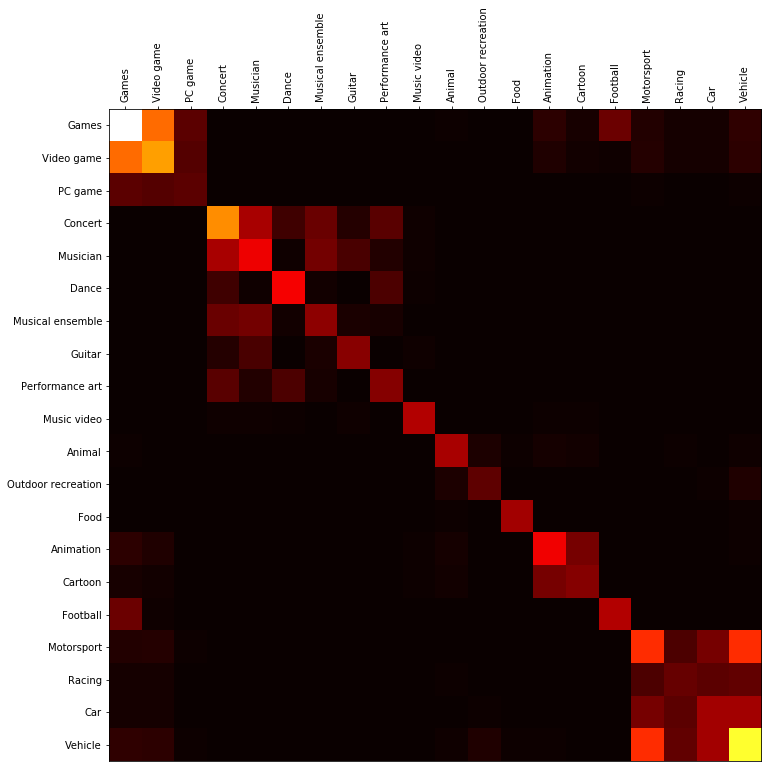

In [8]:
# too much manual adjustment!
co_mat_dense = co_mat[:20, :20].todense()
co_mat_dense[[1, 2], :] = co_mat_dense[[2, 1], :]
co_mat_dense[:, [1, 2]] = co_mat_dense[:, [2, 1]]
co_mat_dense[[2, 19], :] = co_mat_dense[[19, 2], :]
co_mat_dense[:, [2, 19]] = co_mat_dense[:, [19, 2]]
co_mat_dense[[4, 7], :] = co_mat_dense[[7, 4], :]
co_mat_dense[:, [4, 7]] = co_mat_dense[:, [7, 4]]
co_mat_dense[[6, 13], :] = co_mat_dense[[13, 6], :]
co_mat_dense[:, [6, 13]] = co_mat_dense[:, [13, 6]]
co_mat_dense[[7, 14], :] = co_mat_dense[[14, 7], :]
co_mat_dense[:, [7, 14]] = co_mat_dense[:, [14, 7]]
co_mat_dense[[8, 16], :] = co_mat_dense[[16, 8], :]
co_mat_dense[:, [8, 16]] = co_mat_dense[:, [16, 8]]
co_mat_dense[[11, 18], :] = co_mat_dense[[18, 11], :]
co_mat_dense[:, [11, 18]] = co_mat_dense[:, [18, 11]]
co_mat_dense[[14, 16], :] = co_mat_dense[[16, 14], :]
co_mat_dense[:, [14, 16]] = co_mat_dense[:, [16, 14]]
co_mat_dense[[14, 15], :] = co_mat_dense[[15, 14], :]
co_mat_dense[:, [14, 15]] = co_mat_dense[:, [15, 14]]
plt.figure(figsize=(12, 12))
plt.imshow(co_mat_dense, cmap='hot', interpolation='nearest')
plt.xticks(range(20), labels['label_name'][[0, 2, 19, 3, 7, 5, 13, 14, 16]\
                                           + [9, 10, 18, 12, 6, 15, 8, 11]\
                                           + [17, 4, 1]], rotation='vertical')
plt.yticks(range(20), labels['label_name'][[0, 2, 19, 3, 7, 5, 13, 14, 16]\
                                           + [9, 10, 18, 12, 6, 15, 8, 11]\
                                           + [17, 4, 1]], rotation='horizontal')
plt.gca().xaxis.tick_top()
plt.show()

We are able to identify certain content groups (like "gaming", "music" and "vehicles") as well as some inter-group relationships ("vehicle" group videos sometimes also belong to the "gaming" group). However, this viusalisation does not scale well when we expand the number of labels investigated from 20 to 200, for example. For such cases we need to perform a hierachical clustering on the labels based on their coincidence matrix.

Below is the result of running Hierarchical Stochastic Blockmodel Inference algorithm on the coincidence data for the top 200 labels.

![clustering](./hsbm-fit-latest.svg)

From this cluster graph, we are able to infer several interesting patterns. For instance:
1. The majority of the popular classes fall into one of two major categories. The labels on top roughly fall into the "lifestyle and activities" group, and the ones below roughly fall into the "arts and fashion" group.
2. The largest group on top is the "games" group (left), which can be subdivided into "video games" (dark green) and "sports" (grey). Interestingly, the clustering algorithm put most team competitive sports here with video games and put most "solo" sports in a separate cluster (top right, light purple). The graph suggests that the "solo" sports have just as much in common with the team sports as with the "vehicles" cluster (right, steelblue).
3. Other group on top include "farming and gardening" (light yellow), "cooking" (green) and "hobbies" (dark yellow).
4. "Music" (dark pink) form a large group in the bottom branch. "Fashion" and "gadgets" form their own group at the bottom. Surporisingly, much of "pop culture" is assigned to the same cluster on the bottom right, however we can actually see that there is actually a "cartoon" cluster with some loosely connected pop culture labels attached to it. They would likely be separate clusters if we alter the algorithm's parameters.

Using this clustering map, we are able to assign a large proportion of the videos in the entire sample to a particular content group, and investigate the properties of videos in each cluster and compare their similarities and differences. However, before doing so, we have to collect additional metadata about the videos in question.

We run a script to retrieve the following additional information about the tagged videos:
+ duration
+ title
+ channel ID
+ channel title
+ publish datetime
+ views
+ likes (if enabled)
+ dislikes (if enabled)
+ comment count (if enabled)

The number of total videos in the sample is too large for the script to retrieve by Youtube API in limited time. Therefore, we take a slice of our entire sample videos to generate a smaller sample as a first step.

The retrieved data are converted into the following format:

In [10]:
from datetime import datetime
from ggplot import *
import pickle
import feather
from scipy.io import mmread

In [11]:
sample = feather.read_dataframe("./sample_larger.feather")
sample.head()

,video_id,duration,title,channel_id,channel_title,published_at,views,likes,dislikes,comments
0,--DwgB78t-c,PT2M36S,Fruto Dulce - Geraldine Rojas & Ezequiel Paludi 3,UCdzU3DSGzyWzN2118yd9X9g,Abdullah AYDIN,2012-01-19 18:20:02,1671,10,1,0
1,--NZRkXBV7k,PT4M53S,Carlos Santana presents Cindy Blackman in Mexi...,UC0UnhAG47DRyVZGVcbhAXhQ,Saul TP,2015-03-30 04:04:40,9994,41,3,2
2,--hoQ2sGG4M,PT4M35S,"Taoist monk Tian Xin Shan in Brazil,Wudang San...",UCXjtAvK5P3wXBGh0vbGylzg,TheTVtaoista,2009-08-07 06:36:33,3407,8,1,2
3,--sBoaqBlzA,PT8M19S,"MAKEUP FOR GUYS: Actors, TV Hosts, On Camera ...",UCeKHMeUlcLNPLCLUfZUQI2w,Tiffany Hendra,2011-08-04 00:47:49,15816,120,2,8
4,--7h1S4neDM,PT3M19S,Pet Rescue Saga Level 539 2 Stars No Boosts,UCNWPDyaWf2eAHnofFLSnEMg,All Gamers,2014-04-29 15:44:44,2167,1,0,0


**Some notes about the collected video metadata:**
1. Some of the videos have missing titles. This is not important right now, but must be dealt with when analysing the relationship between title and other video properties.
2. Not all videos have likes, dislikes and comments (the video owner can disable them). In the script used to fetch the data, missing values are stored as -999. In the subsequent statistics analysis, only values greater or equal to zero will be used to filter out the missing values.

First we compare some simple statistics between the most popular tags.

In [12]:
sample_top = feather.read_dataframe("./sample_top.feather")

In [13]:
durations = pd.to_timedelta(sample_top['duration'].apply(lambda s: s[2:]))
sample_top['duration'] = durations

In [14]:
labels = pickle.load(open('./labels.pkl', 'rb'))

In [15]:
from scipy import stats

In [16]:
rows = []
for n in range(20):
    selected = sample_top.ix[sample_top[str(n)] == 1, :]
    label_name = labels['label_name'][n]
    rows += [[label_name, 
              stats.trim_mean(selected['views'], 0.1),
              stats.trim_mean(selected.query('likes >= 0')['likes'], 0.1),
              stats.trim_mean(selected.query('dislikes >= 0')['dislikes'], 0.1), 
              stats.trim_mean(selected.query('comments >= 0')['comments'], 0.1), 
              stats.trim_mean(selected['duration'] / np.timedelta64(1, 's'), 0.1)]]
rows = pd.DataFrame(rows)
rows.columns = ['tag', 'views', 'likes', 'dislikes', 'comments', 'seconds']

**Trimmed mean of view count for top 20 labels:**

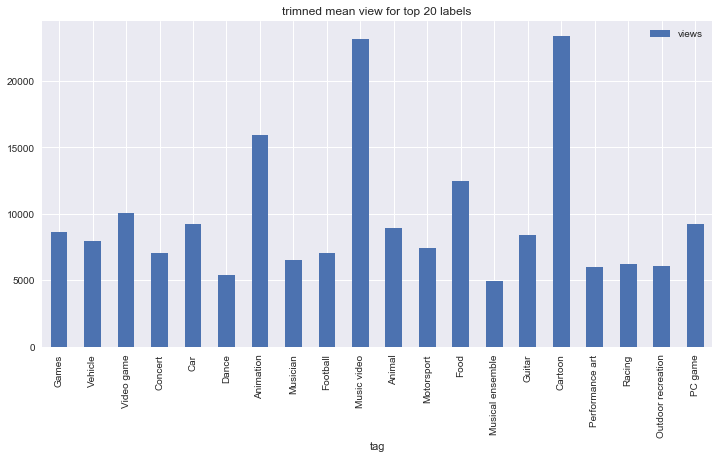

In [34]:
import seaborn as sns
sns.set()
rows.plot.bar(x='tag', y='views', figsize=(12, 6))
plt.title('trimned mean view for top 20 labels')
plt.show()

Since there is a lower limit on the minimum views for videos in this sample, the median view count is not representative of all videos on Youtube with the given tag. However, it is an indicator of the popularity of a particular content type for the more popular videos.

**Trimmed average likes vs dislikes for top 20 labels:**

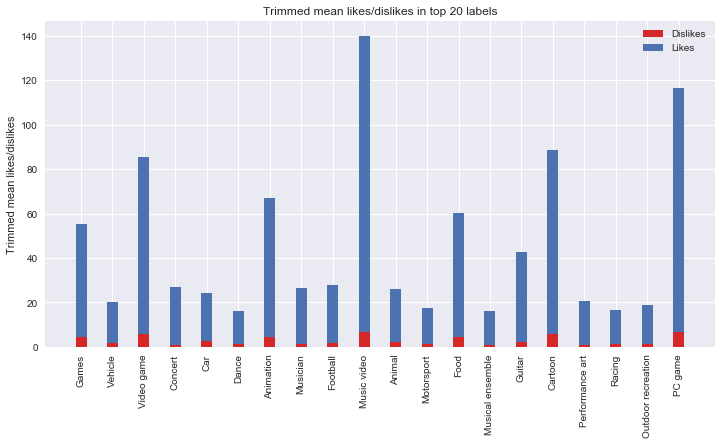

In [35]:
plt.figure(figsize=(12, 6))
ind = np.arange(20)
width = 0.35
p1 = plt.bar(ind, rows['dislikes'], width, color='#d62728')
p2 = plt.bar(ind, rows['likes'], width,
             bottom=rows['dislikes'])

plt.ylabel('Trimmed mean likes/dislikes')
plt.title('Trimmed mean likes/dislikes in top 20 labels')
plt.xticks(ind, rows['tag'], rotation='vertical')
plt.legend((p1[0], p2[0]), ('Dislikes', 'Likes'))
plt.show()

Here we are able to compare viewers' median reception of videos under each label and the "positivity" of each labels. We can see that viewers of "concert", "music ensemble" and "performance art" videos appear to feel more positive towards the videos, although they are less likely to receive a large number of likes. This confirms my intuition that many videos under these categories such as concert recordings and cover songs usually do not receive a large number of views (except the viral ones) but they are often well-liked by their small audience. On the other hand, gaming videos and cartoon / anime receive more views and likes on average, but the fans of these categories are also more divided.

**Duration of videos**

When looking at the overall duration distribution of the videos, we find a interesting pattern.

In [21]:
sample = feather.read_dataframe("./sample_larger.feather")
durations = pd.to_timedelta(sample['duration'].apply(lambda s: s[2:]))
sample['duration'] = durations

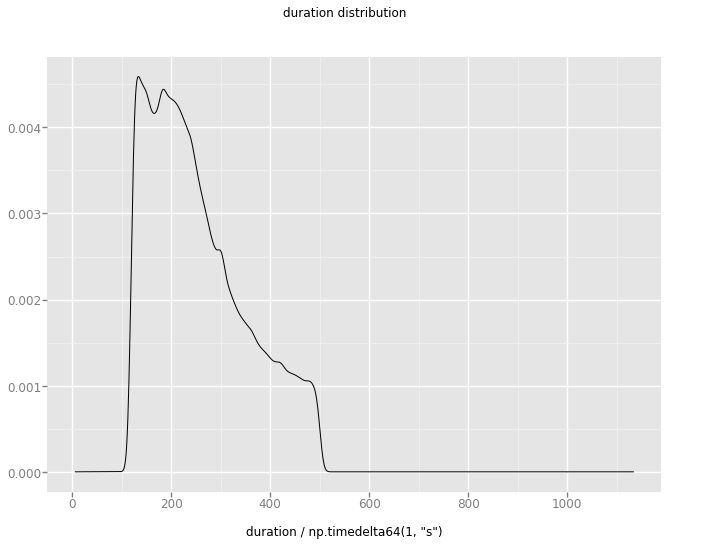

<ggplot: (-9223363304059612030)>

In [8]:
ggplot(sample, aes(x='duration / np.timedelta64(1, "s")')) + geom_density() + ggtitle("duration distribution")

As we see, the distribution of video duration in seconds is not the shape of any typical distributions. This is due to the sampling cut-off. Only videos from 120s to 500s are included in the sample. However, we can still reasonably estimate the shape of the distribution outside of the duration range. Video duration in the entire Youtube collection probably peak around 100s, and the frequency of videos longer than 500s is likely to decline gradually as the duration increases.

**Inequality**

Another statistic worth looking at the the measure of "view count inequality" among Youtube channels. Since the sampling process excludes all videos under 1000 views, when calculating this measure, the contribution of channels with low views will not be accurate. This can at best be a rough estimate of view count distribution among the more regular content creators who are able to hit above 1000 views for most videos.

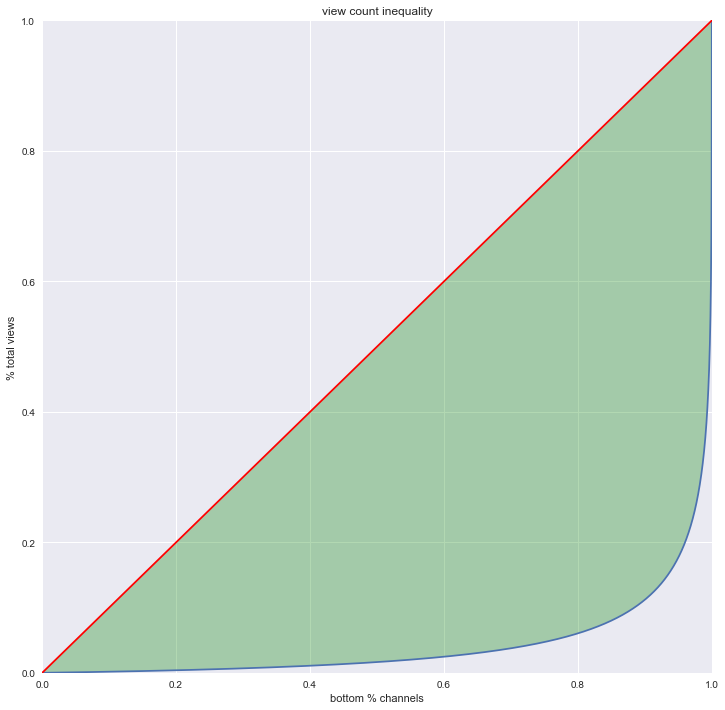

In [37]:
channel_views = sample.groupby('channel_id')['views'].sum().sort_values()
cumsums = [0]
for n in channel_views:
    cumsums += [cumsums[-1] + n]
cum_table = pd.DataFrame({'percentile': np.linspace(0, 1, len(cumsums)), 'cum_views': cumsums / cumsums[-1]})
plt.figure(figsize=(12, 12))
plt.plot(cum_table['percentile'], cum_table['cum_views'])
plt.plot([0, 1], [0, 1], color='red')
plt.fill_between(cum_table['percentile'],
                 cum_table['cum_views'],
                 cum_table['percentile'], 
                 where=cum_table['percentile'] >= cum_table['cum_views'], 
                 facecolor='green', 
                 alpha=0.3,
                 interpolate=True)
plt.title("view count inequality")
plt.ylabel("% total views")
plt.xlabel("bottom % channels")
plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)
plt.show()

The red curve is the cumulative distribution of views if it were completely evenly distributed. The blue curve is the actual cumulative views of the bottom x% channels. The area enclosed by these two curves defines the gini coefficient.

In [38]:
auc = np.trapz(cum_table['cum_views'], cum_table['percentile'])
print("gini = {0}".format(1 - 2 * auc))

gini = 0.914961124317161


As we see, Youtube video views has an extremely high gini coefficient, with top 1% of the channels taking over almost 80% of the views. In comparison, the top 1% of world population "only" hold about 50% of world wealth.

### assign label membership

Now we read the top 200 label clustering results from earlier and generate a membership table for top 200 labels. The goal is to find the group membership of the list of videos we have. This allows us to deal with much less categories of videos than the 200 most popular labels we have. First we extract the top 200 labels' indicator matrix.

In [39]:
memb = [[0, 3, 0, 2, 3, 2, 4, 2, 5, 2, 6, 3, 7, 2, 2, 4, 2, 3, 6, 0, 2, 5, 6, 8, 2, 2, 7, 3, 4, 8, 2, 2, 7, 0, 0, 0, 1, 8, 2, 2, 3, 3, 6, 0, 2, 4, 2, 8, 6, 2, 9, 0, 7, 1, 5, 0, 4, 3, 7, 1, 5, 4, 10, 2, 10, 5, 2, 1, 2, 1, 3, 6, 8, 5, 1, 4, 5, 5, 4, 5, 6, 5, 9, 6, 1, 4, 6, 6, 2, 4, 5, 6, 9, 2, 3, 2, 0, 4, 2, 2, 2, 8, 9, 10, 1, 3, 4, 1, 6, 7, 2, 0, 1, 6, 2, 2, 2, 4, 0, 10, 1, 4, 2, 4, 6, 2, 2, 0, 2, 9, 2, 8, 6, 2, 0, 3, 6, 6, 0, 9, 2, 8, 1, 10, 2, 8, 2, 6, 4, 9, 2, 9, 10, 4, 1, 4, 6, 9, 1, 2, 9, 10, 2, 2, 2, 0, 6, 1, 5, 3, 6, 2, 3, 4, 6, 9, 0, 1, 8, 7, 5, 0, 6, 4, 7, 4, 2, 9, 9, 8, 4, 2, 0, 4, 0, 4, 4, 1, 1, 0], [0, 1, 2, 1, 2, 0, 3, 3, 2, 3, 1], [0, 0, 1, 1], [0, 0]]

In [40]:
import warnings
warnings.filterwarnings('ignore')
label_members = labels[:200]
label_members['G0'] = memb[0]
label_members['G1'] = [memb[1][i] for i in label_members['G0']]
label_members['G2'] = [memb[2][i] for i in label_members['G1']]
warnings.filterwarnings('default')

In [41]:
import feather
feather.write_dataframe(label_members, "label_members.feather")

In [44]:
binary_mat_top = binary_mat[:, :200].todense()

We create the map from G0 groups to all corresponding labels:

In [45]:
label_association = label_members.groupby('G0')['label_id'].unique()
print(label_association)

G0
0     [0, 2, 19, 33, 34, 35, 43, 51, 55, 96, 111, 11...
1     [36, 53, 59, 67, 69, 74, 84, 104, 107, 112, 12...
2     [3, 5, 7, 9, 13, 14, 16, 20, 24, 25, 30, 31, 3...
3     [1, 4, 11, 17, 27, 40, 41, 57, 70, 94, 105, 13...
4     [6, 15, 28, 45, 56, 61, 75, 78, 85, 89, 97, 10...
5     [8, 21, 54, 60, 65, 73, 76, 77, 79, 81, 90, 16...
6     [10, 18, 22, 42, 48, 71, 80, 83, 86, 87, 91, 1...
7                   [12, 26, 32, 52, 58, 109, 179, 184]
8     [23, 29, 37, 47, 72, 101, 131, 141, 145, 178, ...
9     [50, 82, 92, 102, 129, 139, 149, 151, 157, 160...
10                    [62, 64, 103, 119, 143, 152, 161]
Name: label_id, dtype: object


Now we are ready to create the group membership map from video_id to groups.

In [46]:
video_memb = videos
for i in range(11):
    video_memb[str(i)] = np.apply_along_axis(lambda row: 1 * (np.sum(row) > 0), 1, 
                                             binary_mat_top[:, label_association[i]])

Merging the membership with the video metadata table and we are ready for the next step of analysis:

In [47]:
grouped_sample = sample.merge(video_memb, on='video_id')

In [25]:
# grouped_sample.to_csv("grouped_sample_larger.csv")

In [120]:
# with open("grouped_sample_larger.pkl", "wb") as f:
#     pickle.dump(grouped_sample, f)
#     f.close()

### Content Group Characteristics Analysis

We first try to assign a summary label to each content groups:

The content groups we obtained earlier:

    0. Gaming
    1. Misc. Hobbies
    2. Music & Entertainment
    3. Vehicles
    4. Animation & Fashion
    5. Sports
    6. Outdoors & Pets
    7. Food & Cooking
    8. Gadgets
    9. Aircraft
    10. Transportation

In [48]:
rows = []
group_names = ["Gaming", "Misc. Hobbies", "Music & Entertainment", "Vehicles", "Animation & Fashion",
             "Sports", "Outdoors & Pets", "Food & Cooking", "Gadgets", "Aircraft", "Transportation"]
for n in range(11):
    selected = grouped_sample.ix[grouped_sample[str(n)] == 1, :]
    group_name = group_names[n]
    rows += [[group_name, 
              stats.trim_mean(selected['views'], 0.1),
              stats.trim_mean(selected.query('likes >= 0')['likes'], 0.1),
              stats.trim_mean(selected.query('dislikes >= 0')['dislikes'], 0.1), 
              stats.trim_mean(selected.query('comments >= 0')['comments'], 0.1), 
              stats.trim_mean(selected['duration'] / np.timedelta64(1, 's'), 0.1)]]
rows = pd.DataFrame(rows)
rows.columns = ['group', 'views', 'likes', 'dislikes', 'comments', 'seconds']

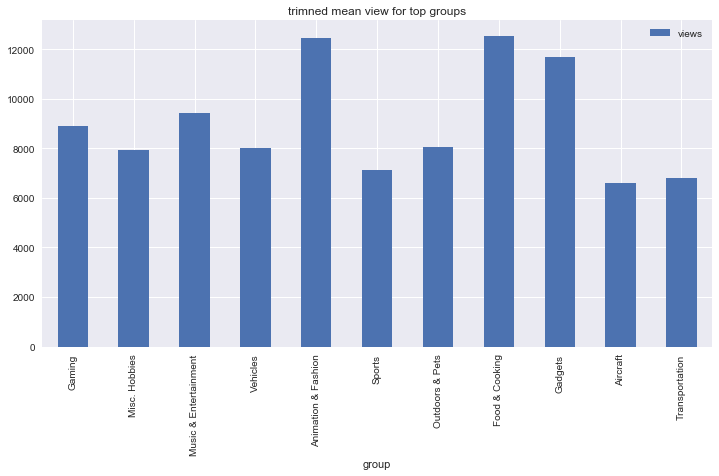

In [49]:
rows.plot.bar(x='group', y='views', figsize=(12, 6))
plt.title('trimned mean view for top groups')
plt.show()

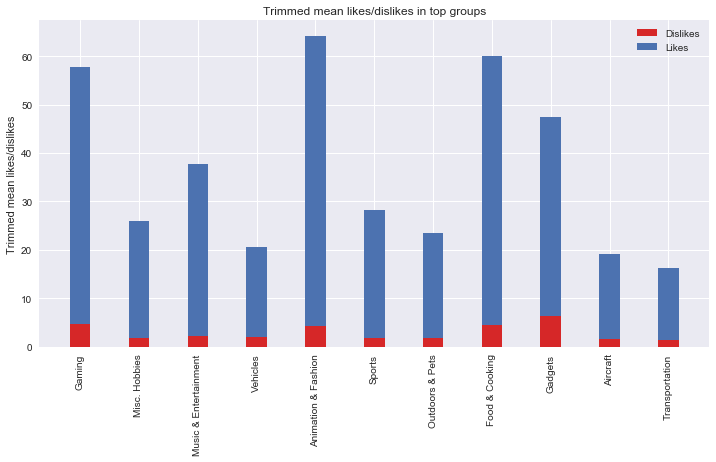

In [50]:
plt.figure(figsize=(12, 6))
ind = np.arange(11)
width = 0.35
p1 = plt.bar(ind, rows['dislikes'], width, color='#d62728')
p2 = plt.bar(ind, rows['likes'], width,
             bottom=rows['dislikes'])

plt.ylabel('Trimmed mean likes/dislikes')
plt.title('Trimmed mean likes/dislikes in top groups')
plt.xticks(ind, rows['group'], rotation='vertical')
plt.legend((p1[0], p2[0]), ('Dislikes', 'Likes'))
plt.show()